## 1. <font color = red> Install and Import the Required Libraries

In [25]:
# Install all the required libraries
!pip install -U -q pdfplumber tiktoken openai chromadb sentence-transformers

In [28]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

In [30]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 2. <font color = red> Read, Process PDF File

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

In [31]:
# Define the path of the PDF
single_pdf_path = "/content/drive/My Drive/Colab Notebooks/Policy+Documents/Principal-Sample-Life-Insurance-Policy.pdf"

#### <font color = red>  2.1 Reading a single PDF file and exploring it through pdfplumber

In [32]:
# Open the PDF file
with pdfplumber.open(single_pdf_path) as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[6]

    # Extract text from the first page
    text = single_page.extract_text()

    # Extract tables from the first page
    tables = single_page.extract_tables()

    # Print the extracted text
    print(text)

Section A – Eligibility
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section B - Effective Dates
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section C - Individual Terminations
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Termination for Fraud Article 4
Coverage While Outside of the United States Article 5
Section D - Continuation
Member Life Insurance Article 1
Dependent Insurance - Developmentally Disabled or
Physically Handicapped Children Article 2
Section E - Reinstatement
Reinstatement Article 1
Federal Required Family and Medical Leave Act (FMLA) Article 2
Reinstatement of Coverage for a Member or Dependent When
Coverage Ends due to Living Outside of the United States Article 3
Section F - Individual Purchase Rights
Member Life In

In [33]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [34]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

*Now that we have defined the function for extracting the text and tables from

*   List item
*   List item

a PDF, let's iterate and call this function for all the PDFs in our drive and store them in a list.*

In [35]:

# Initialize an empty list to store the extracted texts and document names
data = []

# Process the PDF file
print(f"...Processing {single_pdf_path}")

# Call the function to extract the text from the PDF
extracted_text = extract_text_from_pdf(single_pdf_path)

# Convert the extracted list to a PDF, and add a column to store document names
extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])

# Append the extracted text and document name to the list
data.append(extracted_text_df)

# Print a message to indicate progress
print(f"Finished processing {single_pdf_path}")

# Print a message to indicate all PDFs have been processed
print("PDF have been processed.")

...Processing /content/drive/My Drive/Colab Notebooks/Policy+Documents/Principal-Sample-Life-Insurance-Policy.pdf
Finished processing /content/drive/My Drive/Colab Notebooks/Policy+Documents/Principal-Sample-Life-Insurance-Policy.pdf
PDF have been processed.


In [36]:
data

[   Page No.                                          Page_Text
 0    Page 1  DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...
 1    Page 2                 This page left blank intentionally
 2    Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...
 3    Page 4                 This page left blank intentionally
 4    Page 5  PRINCIPAL LIFE INSURANCE COMPANY (called The P...
 ..      ...                                                ...
 59  Page 60  I f a Dependent who was insured dies during th...
 60  Page 61  Section D - Claim Procedures Article 1 - Notic...
 61  Page 62  A claimant may request an appeal of a claim de...
 62  Page 63                 This page left blank intentionally
 63  Page 64  Principal Life Insurance Company Des Moines, I...
 
 [64 rows x 2 columns]]

In [37]:
insurance_pdfs_data = pd.concat(data, ignore_index=True)

In [38]:
insurance_pdfs_data

,Page No.,Page_Text
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...
1,Page 2,This page left blank intentionally
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...
3,Page 4,This page left blank intentionally
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...
...,...,...
59,Page 60,I f a Dependent who was insured dies during th...
60,Page 61,Section D - Claim Procedures Article 1 - Notic...
61,Page 62,A claimant may request an appeal of a claim de...
62,Page 63,This page left blank intentionally


In [39]:
# Store the metadata for each page in a separate column
insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Page_No.': x['Page No.']}, axis=1)
insurance_pdfs_data

,Page No.,Page_Text,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,{'Page_No.': 'Page 1'}
1,Page 2,This page left blank intentionally,{'Page_No.': 'Page 2'}
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,{'Page_No.': 'Page 3'}
3,Page 4,This page left blank intentionally,{'Page_No.': 'Page 4'}
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,{'Page_No.': 'Page 5'}
...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,{'Page_No.': 'Page 60'}
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,{'Page_No.': 'Page 61'}
61,Page 62,A claimant may request an appeal of a claim de...,{'Page_No.': 'Page 62'}
62,Page 63,This page left blank intentionally,{'Page_No.': 'Page 63'}


In [40]:
# Check one of the extracted page texts to ensure that the text has been correctly read
insurance_pdfs_data.Page_Text[2]

'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees of that employer group. In addition, The Principal may arrange for third party service providers (i.e., optometrists, health clubs), to provide discounted goods and services to those employer groups who apply for coverage with The Principal or who become insureds/enrollees of The Principal. While The Principal has arranged these goods, services and/or third party provider discounts, the third party service providers are liable to the applicants/insureds/enrollees for the provision of such goods and/or services. The Principal is not responsible for the

In [41]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop
insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [42]:
insurance_pdfs_data['Text_Length']

,Text_Length
0,30
1,5
2,230
3,5
4,110
...,...
59,285
60,418
61,322
62,5


In [43]:
insurance_pdfs_data

,Page No.,Page_Text,Metadata,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,{'Page_No.': 'Page 1'},30
1,Page 2,This page left blank intentionally,{'Page_No.': 'Page 2'},5
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,{'Page_No.': 'Page 3'},230
3,Page 4,This page left blank intentionally,{'Page_No.': 'Page 4'},5
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,{'Page_No.': 'Page 5'},110
...,...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,{'Page_No.': 'Page 60'},285
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,{'Page_No.': 'Page 61'},418
61,Page 62,A claimant may request an appeal of a claim de...,{'Page_No.': 'Page 62'},322
62,Page 63,This page left blank intentionally,{'Page_No.': 'Page 63'},5


## 3. <font color = 'red'> Document Chunking </font>

We will generate embeddings for texts related to various Wikipedia articles. But since you are using large blocks of text, before generating the embeddings, you need to generate the chunks. Let's start with a basic chunking technique, and chunk the text by paragraph.
#### Chunking for multiple documents
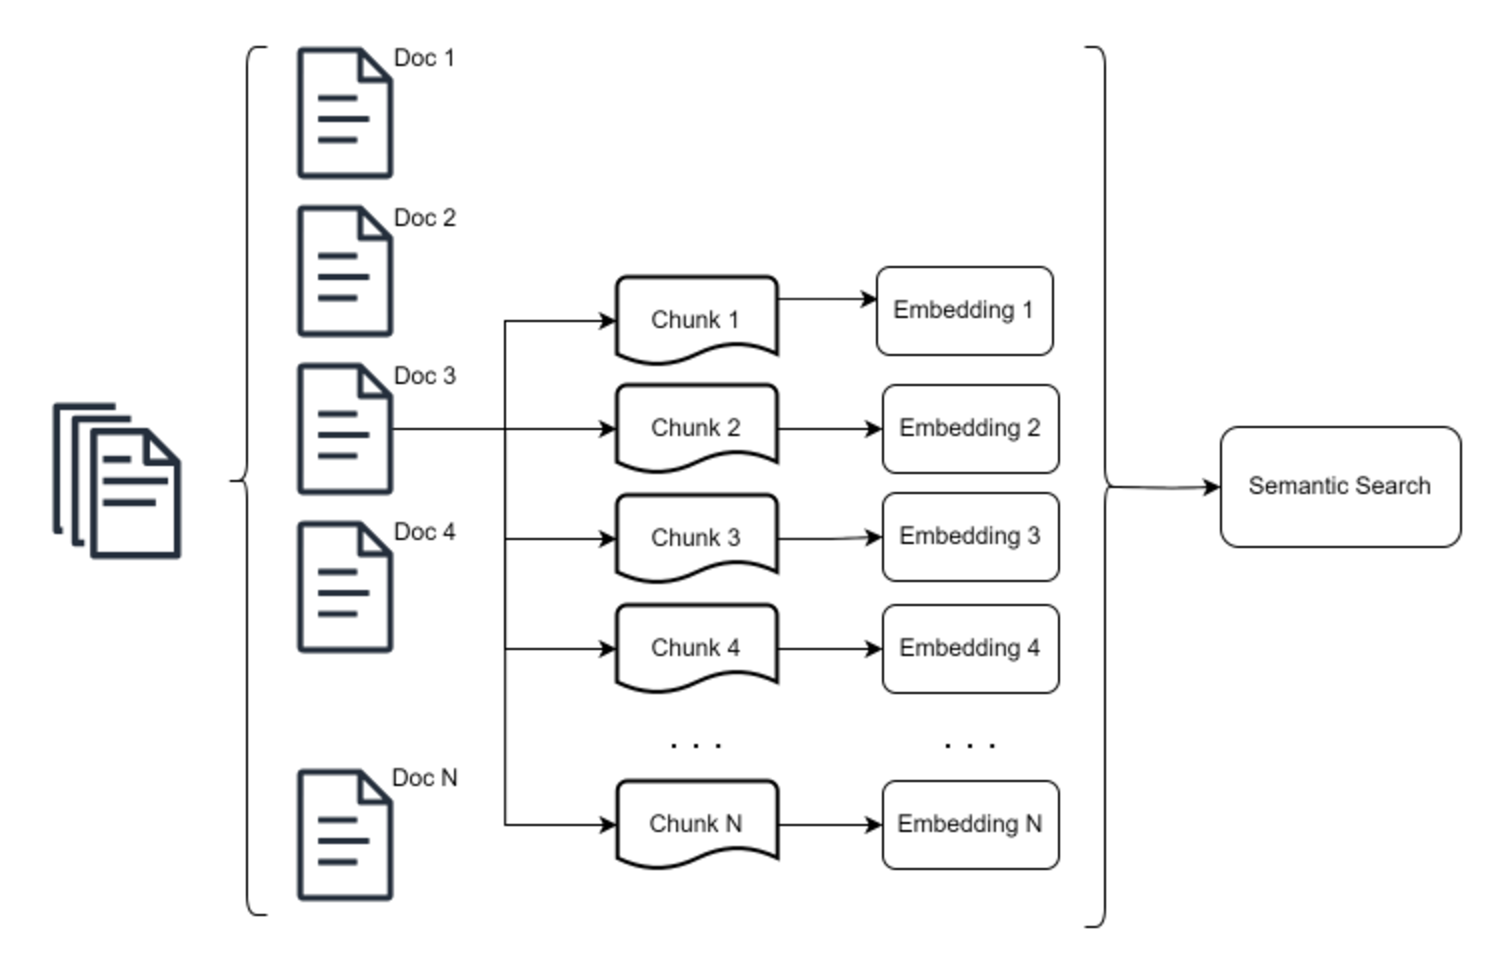

In [44]:
# Check the entire page's text
insurance_pdfs_data[['Page_Text']]

,Page_Text
0,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...
1,This page left blank intentionally
2,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...
3,This page left blank intentionally
4,PRINCIPAL LIFE INSURANCE COMPANY (called The P...
...,...
59,I f a Dependent who was insured dies during th...
60,Section D - Claim Procedures Article 1 - Notic...
61,A claimant may request an appeal of a claim de...
62,This page left blank intentionally


In [45]:
# Iterating over all page titles to create the final df with individual chunks
page_nos = insurance_pdfs_data[["Page No."]]
page_nos

,Page No.
0,Page 1
1,Page 2
2,Page 3
3,Page 4
4,Page 5
...,...
59,Page 60
60,Page 61
61,Page 62
62,Page 63


### 2.1 <font color = 'red'> Fixed-Size Chunking </font>

In fixed-size chunking, the document is split into fixed-size windows with each window representing a separate document chunk.

In [46]:
# Function to split text into fixed-size chunks

def split_text_into_chunks(text, chunk_size):
    chunks = []
    words = text.split()  # Split the text into words

    current_chunk = []  # Store words for the current chunk
    current_chunk_word_count = 0  # Count of words in the current chunk

    for word in words:
        if current_chunk_word_count + len(word) + 1 <= chunk_size:
            current_chunk.append(word)
            current_chunk_word_count += len(word) + 1
        else:
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_chunk_word_count = len(word)

    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks## 3. <font color = 'red'> Generating Embeddings </font>

#### Encoding Pipeline

In [51]:
def process_page(page_no):
    page = insurance_pdfs_data[insurance_pdfs_data['Page No.'] == page_no].Page_Text.values[0]
    metadata = insurance_pdfs_data[insurance_pdfs_data['Page No.'] == page_no].Metadata.values[0]

    if page is not None:
        chunk_size = 1000  # Set your desired chunk size (in characters)

        text_chunks = split_text_into_chunks(page, chunk_size)

        # Create a DataFrame to store the chunks, page title and page metadata
        data = {'Title': [], 'Chunk Text': [], 'Metadata': []}

        for idx, chunk in enumerate(text_chunks):
            data['Title'].append(page_no)
            data['Chunk Text'].append(chunk)
            metadata['Chunk_No.'] = idx
            data['Metadata'].append(metadata)

        return pd.DataFrame(data)

In [53]:
all_dfs = []
for page_no in page_nos:
    df = process_page(page_no)
    if df is not None:
        all_dfs.append(df)

fixed_chunk_df = pd.concat(all_dfs, ignore_index=True)
fixed_chunk_df

,Title,Chunk Text,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,"{'Page_No.': 'Page 1', 'Chunk_No.': 0}"
1,Page 2,This page left blank intentionally,"{'Page_No.': 'Page 2', 'Chunk_No.': 0}"
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,"{'Page_No.': 'Page 3', 'Chunk_No.': 1}"
3,Page 3,provision of such goods and/or services nor is...,"{'Page_No.': 'Page 3', 'Chunk_No.': 1}"
4,Page 4,This page left blank intentionally,"{'Page_No.': 'Page 4', 'Chunk_No.': 0}"
...,...,...,...
129,Page 61,claim. Written notification will be sent to th...,"{'Page_No.': 'Page 61', 'Chunk_No.': 2}"
130,Page 62,A claimant may request an appeal of a claim de...,"{'Page_No.': 'Page 62', 'Chunk_No.': 1}"
131,Page 62,have the Member or Dependent whose loss is the...,"{'Page_No.': 'Page 62', 'Chunk_No.': 1}"
132,Page 63,This page left blank intentionally,"{'Page_No.': 'Page 63', 'Chunk_No.': 0}"


## 4. <font color = 'red'> Generating Embeddings </font>

#### Encoding Pipeline
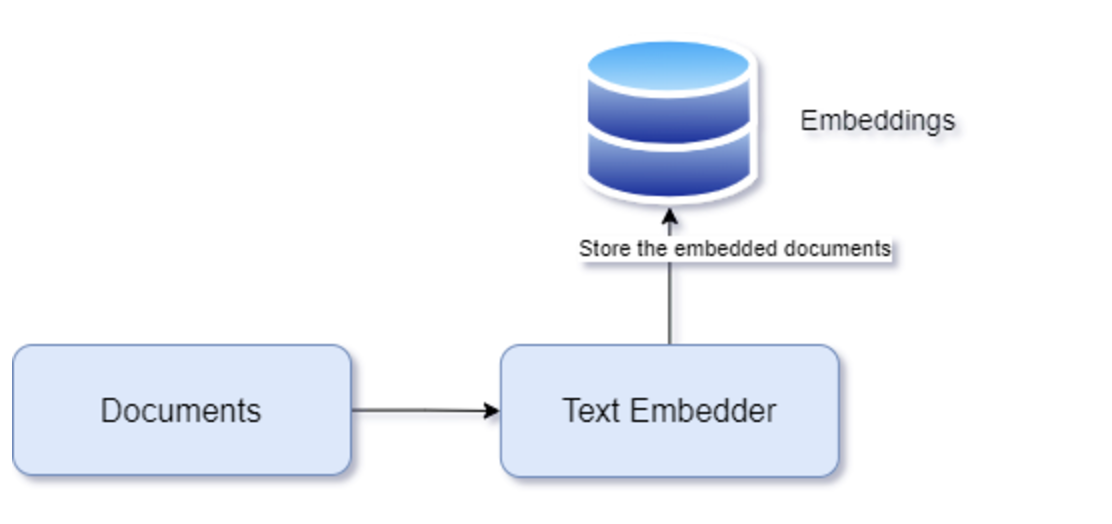

In [54]:
# Install the sentence transformers library
!pip install -q -u sentence-transformers


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


In [56]:
from sentence_transformers import SentenceTransformer, util

In [57]:
# Import the SentenceTransformer library
from sentence_transformers import SentenceTransformer

In [58]:
# Load the embedding model
model_name = "all-MiniLM-L6-v2"
embedder = SentenceTransformer(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [90]:
# Function to generate embeddings for text
def generate_embeddings(texts):
    embeddings = embedder.encode(texts, convert_to_tensor=False)
    return embeddings

In [91]:
def generate_embeddings_on_df(df):
  df['Embeddings'] = df['Chunk Text'].apply(lambda x: generate_embeddings([x])[0])

In [92]:
# Create embeddings for 'Chunk Text' column on all three dataframes
generate_embeddings_on_df(fixed_chunk_df)

In [93]:
fixed_chunk_df

,Title,Chunk Text,Metadata,Embeddings
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,"{'Page_No.': 'Page 1', 'Chunk_No.': 0}","[-0.025921896, 0.04777749, 0.05585775, 0.04239..."
1,Page 2,This page left blank intentionally,"{'Page_No.': 'Page 2', 'Chunk_No.': 0}","[0.029118983, 0.060574077, 0.046415307, 0.0377..."
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,"{'Page_No.': 'Page 3', 'Chunk_No.': 1}","[-0.09329457, 0.0038957002, 0.01330726, -0.046..."
3,Page 3,provision of such goods and/or services nor is...,"{'Page_No.': 'Page 3', 'Chunk_No.': 1}","[-0.081321746, 0.07805485, 0.00863663, -0.0806..."
4,Page 4,This page left blank intentionally,"{'Page_No.': 'Page 4', 'Chunk_No.': 0}","[0.029118983, 0.060574077, 0.046415307, 0.0377..."
...,...,...,...,...
129,Page 61,claim. Written notification will be sent to th...,"{'Page_No.': 'Page 61', 'Chunk_No.': 2}","[-0.14050877, 0.079364605, 0.08539709, -0.0227..."
130,Page 62,A claimant may request an appeal of a claim de...,"{'Page_No.': 'Page 62', 'Chunk_No.': 1}","[-0.053096622, 0.12034012, 0.07282932, -0.0581..."
131,Page 62,have the Member or Dependent whose loss is the...,"{'Page_No.': 'Page 62', 'Chunk_No.': 1}","[-0.13236547, 0.13249458, 0.085313246, -0.0462..."
132,Page 63,This page left blank intentionally,"{'Page_No.': 'Page 63', 'Chunk_No.': 0}","[0.029118983, 0.060574077, 0.046415307, 0.0377..."


## 5. <font color = red> Store Embeddings in ChromaDB

In this section we will store embedding in ChromaDB collection.

In [68]:
# Pip install chromaDB
!pip install chromadb

In [98]:
# Define the path where chroma collections will be stored
chroma_data_path = '/content/drive/My Drive/Colab Notebooks/ChromaDB_Data/'

In [100]:
import chromadb

# Call PersistentClient()
client = chromadb.PersistentClient(path=chroma_data_path)

In [112]:
# Create a collection to store the embeddings. Collections in Chroma are where you can store your embeddings, documents, and any additional metadata.
collection = client.get_or_create_collection(name="insurance-collection")

In [113]:
collection.add(
    embeddings = fixed_chunk_df['Embeddings'].to_list(),
    documents = fixed_chunk_df['Chunk Text'].to_list(),
    metadatas = fixed_chunk_df['Metadata'].to_list(),
    ids = [str(i) for i in range(0, len(fixed_chunk_df['Embeddings']))]
)

In [118]:
collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': array([[-0.0259219 ,  0.04777749,  0.05585775, ..., -0.04932665,
         -0.05851149,  0.02355204],
        [ 0.02911898,  0.06057408,  0.04641531, ...,  0.05954009,
         -0.02838372,  0.00531935],
        [-0.09329457,  0.0038957 ,  0.01330726, ..., -0.03862753,
          0.04017466, -0.02398461]]),
 'documents': ['DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014',
  'This page left blank intentionally',
  'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other

In [115]:
# create a cache collection
cache_collection = client.get_or_create_collection(name='insurance-collection-cache')

In [117]:
# peek few of elements from cache collection
cache_collection.peek()

{'ids': [],
 'embeddings': array([], dtype=float64),
 'documents': [],
 'uris': None,
 'data': None,
 'metadatas': [],
 'included': [<IncludeEnum.embeddings: 'embeddings'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

## 6. <font color = red> Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [120]:
# Read the user query
query = input()

what is the policy on eye issues?


In [121]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results
cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:00<00:00, 106MiB/s]


In [122]:
cache_results

{'ids': [[]],
 'embeddings': None,
 'documents': [[]],
 'uris': None,
 'data': None,
 'metadatas': [[]],
 'distances': [[]],
 'included': [<IncludeEnum.distances: 'distances'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

In [139]:
results = collection.query(
query_texts=query,
n_results=10
)
print("Result size is : " + str(len(results.items())))
results.items()

Result size is : 8


dict_items([('ids', [['18', '112', '21', '42', '11', '31', '71', '22', '76', '83']]), ('embeddings', None), ('documents', [["substantial handicap, as determined by The Principal, which: a. results from mental retardation, cerebral palsy, epilepsy, or other neurological disorder; and b. is diagnosed by a Physician as a permanent or long-term continuing condition. Full-Time Student A Member's Dependent Child attending a school that has a regular teaching staff, curriculum, and student body and who: a. attends school on a full-time basis, as determined by the school's criteria; and b. is dependent on the Member for principal support. Group Policy The policy of group insurance issued to the Policyholder by The Principal, which describes benefits and provisions for insured Members and Dependents. Hospital This policy has been updated effective January 1, 2014 GC 6002 PART I - DEFINITIONS, PAGE 3", 'f . claim requirements listed in PART IV, Section D, must be satisfied; and g. all medical ev

In [141]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      size = len(results.items())

      for key, val in results.items():
        if val is None:
          continue
        for i in range(size):
          Keys.append(str(key)+str(i))
          Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })


Not found in cache. Found in main collection.


In [142]:
results_df

,Metadatas,Documents,Distances,IDs
0,"{'Chunk_No.': 1, 'Page_No.': 'Page 11'}","substantial handicap, as determined by The Pri...",1.238108,18
1,"{'Chunk_No.': 2, 'Page_No.': 'Page 54'}","f . claim requirements listed in PART IV, Sect...",1.244310,112
2,"{'Chunk_No.': 2, 'Page_No.': 'Page 12'}",This policy has been updated effective January...,1.249357,21
3,"{'Chunk_No.': 2, 'Page_No.': 'Page 23'}",Policyholder: a. ceases to be actively engaged...,1.252149,42
4,"{'Chunk_No.': 1, 'Page_No.': 'Page 8'}","policy has been updated effective January 1, 2...",1.257782,11
5,"{'Chunk_No.': 1, 'Page_No.': 'Page 18'}",c . a copy of the form which contains the stat...,1.326620,31
6,"{'Chunk_No.': 1, 'Page_No.': 'Page 36'}","with 31-day notice, upon finding in a civil or...",1.367784,71
7,"{'Chunk_No.': 1, 'Page_No.': 'Page 13'}",a . A licensed Doctor of Medicine (M.D.) or Os...,1.392335,22
8,"{'Chunk_No.': 1, 'Page_No.': 'Page 39'}",self-support or otherwise fails to qualify as ...,1.394147,76
9,"{'Chunk_No.': 2, 'Page_No.': 'Page 42'}",Member Life Insurance or Coverage During Disab...,1.394404,83


## 7. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

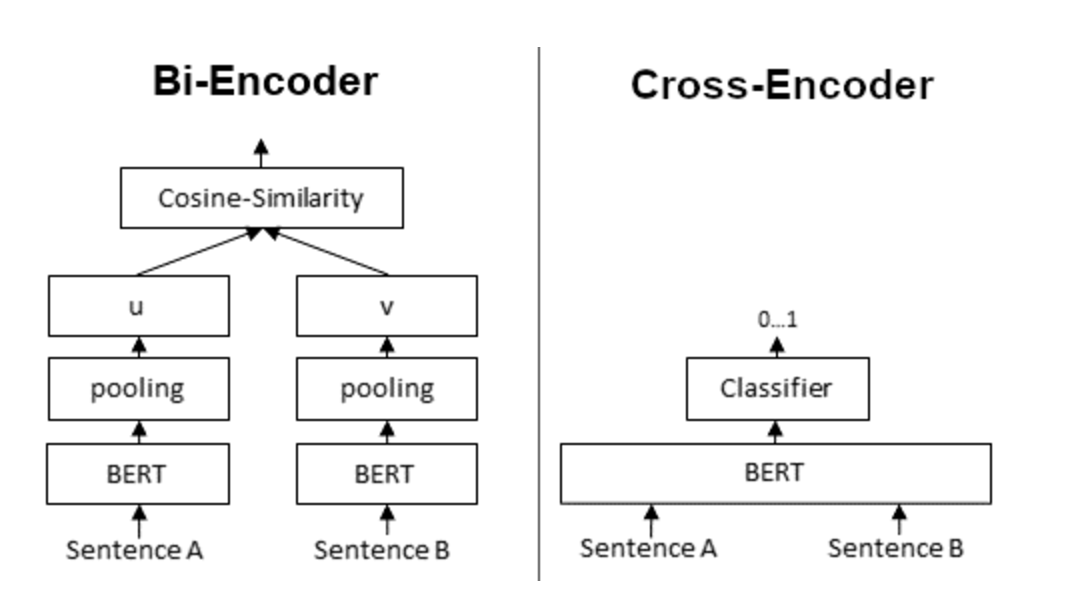

In [143]:
# Import the CrossEncoder library from sentence_transformers
from sentence_transformers import CrossEncoder, util

In [144]:
# Initialise the cross encoder model
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [145]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [146]:
cross_rerank_scores

array([ -9.54728  , -10.287523 ,  -7.6647935, -10.337208 ,  -8.378523 ,
       -10.4861965, -11.067696 ,  -9.955295 , -10.025263 , -10.672431 ],
      dtype=float32)

In [147]:
results_df['Reranked_scores'] = cross_rerank_scores

In [148]:
results_df

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Chunk_No.': 1, 'Page_No.': 'Page 11'}","substantial handicap, as determined by The Pri...",1.238108,18,-9.547280
1,"{'Chunk_No.': 2, 'Page_No.': 'Page 54'}","f . claim requirements listed in PART IV, Sect...",1.244310,112,-10.287523
2,"{'Chunk_No.': 2, 'Page_No.': 'Page 12'}",This policy has been updated effective January...,1.249357,21,-7.664793
3,"{'Chunk_No.': 2, 'Page_No.': 'Page 23'}",Policyholder: a. ceases to be actively engaged...,1.252149,42,-10.337208
4,"{'Chunk_No.': 1, 'Page_No.': 'Page 8'}","policy has been updated effective January 1, 2...",1.257782,11,-8.378523
5,"{'Chunk_No.': 1, 'Page_No.': 'Page 18'}",c . a copy of the form which contains the stat...,1.326620,31,-10.486197
6,"{'Chunk_No.': 1, 'Page_No.': 'Page 36'}","with 31-day notice, upon finding in a civil or...",1.367784,71,-11.067696
7,"{'Chunk_No.': 1, 'Page_No.': 'Page 13'}",a . A licensed Doctor of Medicine (M.D.) or Os...,1.392335,22,-9.955295
8,"{'Chunk_No.': 1, 'Page_No.': 'Page 39'}",self-support or otherwise fails to qualify as ...,1.394147,76,-10.025263
9,"{'Chunk_No.': 2, 'Page_No.': 'Page 42'}",Member Life Insurance or Coverage During Disab...,1.394404,83,-10.672431


In [153]:
# Return the top 3 results from semantic search

top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Chunk_No.': 1, 'Page_No.': 'Page 11'}","substantial handicap, as determined by The Pri...",1.238108,18,-9.547280
1,"{'Chunk_No.': 2, 'Page_No.': 'Page 54'}","f . claim requirements listed in PART IV, Sect...",1.244310,112,-10.287523
2,"{'Chunk_No.': 2, 'Page_No.': 'Page 12'}",This policy has been updated effective January...,1.249357,21,-7.664793


In [154]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
2,"{'Chunk_No.': 2, 'Page_No.': 'Page 12'}",This policy has been updated effective January...,1.249357,21,-7.664793
4,"{'Chunk_No.': 1, 'Page_No.': 'Page 8'}","policy has been updated effective January 1, 2...",1.257782,11,-8.378523
0,"{'Chunk_No.': 1, 'Page_No.': 'Page 11'}","substantial handicap, as determined by The Pri...",1.238108,18,-9.547280


In [157]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]
top_3_RAG

,Documents,Metadatas
2,This policy has been updated effective January...,"{'Chunk_No.': 2, 'Page_No.': 'Page 12'}"
4,"policy has been updated effective January 1, 2...","{'Chunk_No.': 1, 'Page_No.': 'Page 8'}"
0,"substantial handicap, as determined by The Pri...","{'Chunk_No.': 1, 'Page_No.': 'Page 11'}"
